In [1]:
from Imports import *
from Plotting import *
from Helper import *
from Preprocessing import *
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(device)

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

cuda
<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [3]:
dev = qml.device("default.qubit", wires=8)
n_layers = 1

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 3))

@qml.qnode(dev)
def quantum_feature_embedding(f, phi, interface="torch", diff_method="backprop", cachesize=1000000):
    qml.AmplitudeEmbedding(features=f, wires=range(8), normalize=True, pad_with=0.)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(8)))

    # Measurement producing classical output values
    return qml.state()
    # return [qml.expval(qml.PauliZ(j)) for j in range(4)]

state = quantum_feature_embedding(f=[1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4], phi=rand_params)
print(state.shape)

def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    """
    Applies quantum_feature_embedding_single to a batch of inputs.

    Args:
        x_batch (torch.Tensor): (B, D) input batch.
        phi (np.ndarray or torch.Tensor): parameters for RandomLayers.
        device (str): Device to return output on.

    Returns:
        torch.Tensor: Output of shape (B, 2 ** n_qubits)
    """
    outputs = []
    for x in x_batch:
        result = quantum_feature_embedding(x, phi)
        result_tensor = result.real.to(device)
        outputs.append(result_tensor)

    return torch.stack(outputs)

sample = torch.randn(16, 9).to(device)  # Example batch
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)

output = quantum_feature_embedding_batch(sample, phi_tensor)
print(output.shape)

class quantum_feature_embedding_batch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.phi = nn.Parameter(torch.tensor(np.random.uniform(high=2 * np.pi, size=(n_layers, 3)), dtype=torch.float32))
    
    def forward(self, x_batch):
        phi = self.phi
        outputs = []
        for x in x_batch:
            result = quantum_feature_embedding(x, phi)
            result_tensor = result.real.to(device)
            outputs.append(result_tensor)
    
        return torch.stack(outputs)

(256,)
torch.Size([16, 256])


In [4]:
# Generator with Quantum Layer
class Generator(nn.Module):
    def __init__(self, latent_dim=9):
        super().__init__()

        self.noise = GaussianNoise(sigma=0.3)
        
        self.feature_gen = quantum_feature_embedding_batch()

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid()
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat).float()
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
                # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 128

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
   
    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([8726, 16, 16])
dR Mean: torch.Size([8726])
dR STD: torch.Size([8726])
Pixel Mean: torch.Size([8726])
Pixel STD: torch.Size([8726])
ΔR min: 0.0
ΔR max: 2.0372369289398193
ΔR mean min: 0.00444405060261488
ΔR mean max: 0.014574162662029266
ΔR std min: 0.022066839039325714
ΔR std max: 0.1351994276046753
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0029388333205133677
Pixel mean max: 0.004459979943931103
Pixel std min: 0.011304350569844246
Pixel std max: 0.06250042468309402


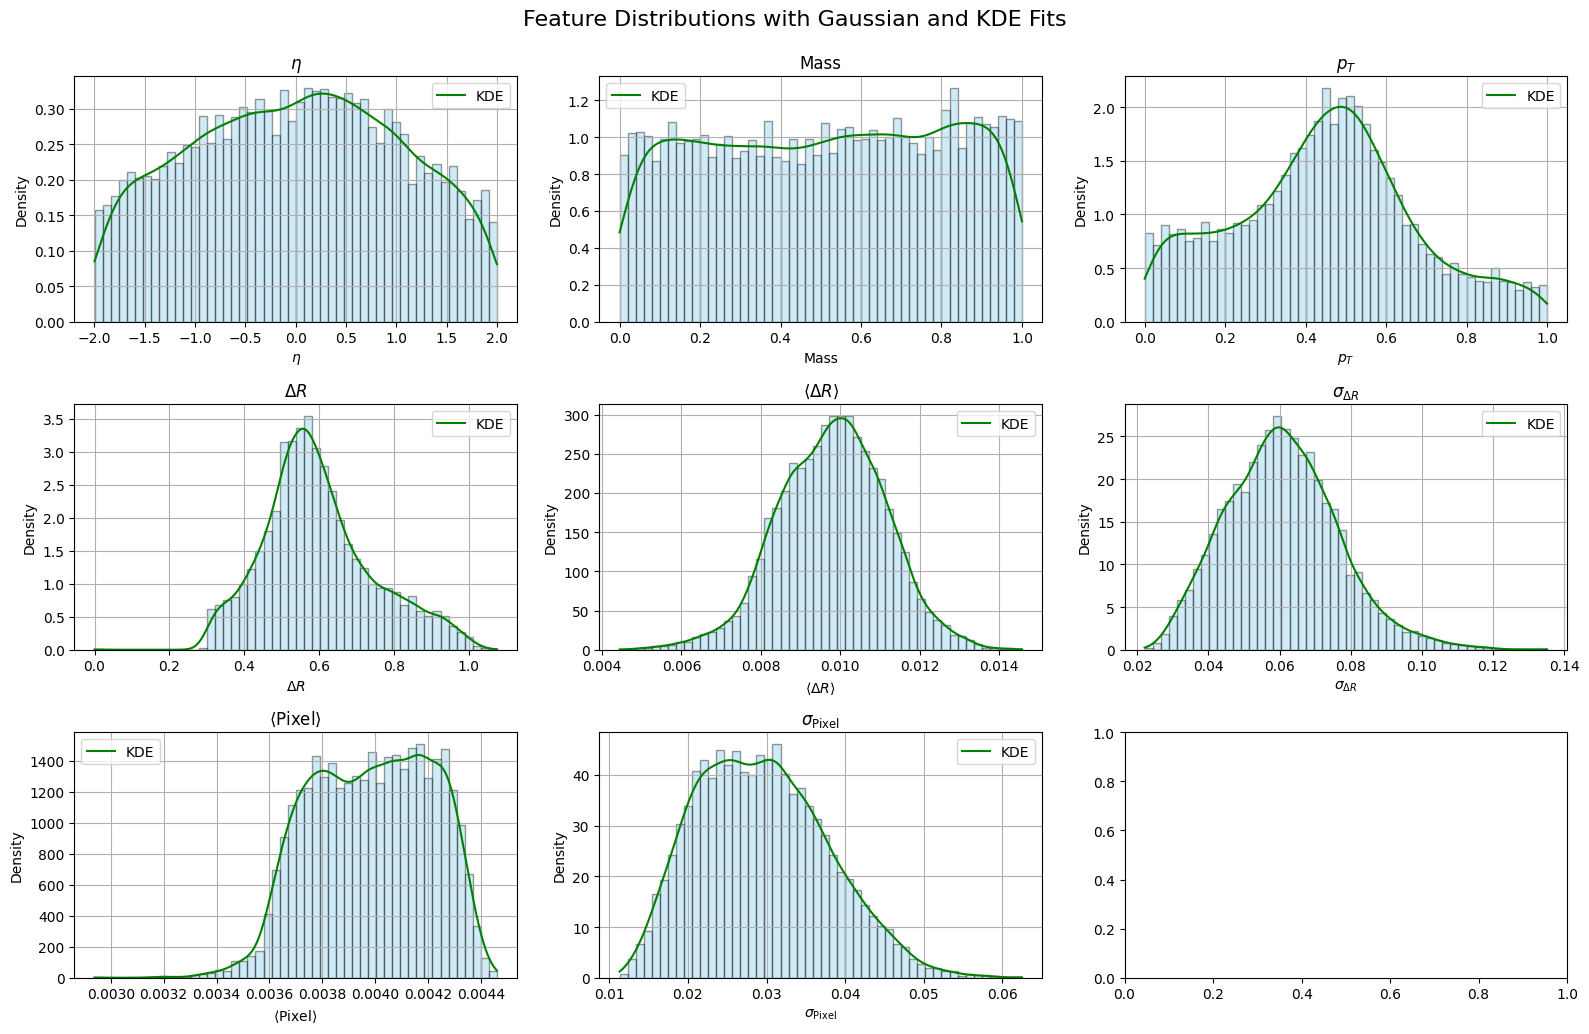

Number of samples: 8726
Image shape: torch.Size([8726, 16, 16])
Feature shape: torch.Size([8726, 9])


In [5]:
batch_size = 128*3
n_events = int(.01 * jet_mass_data['image'].shape[0])

latent_dim = 256
lr = 1e-4
n_epochs = 30
num = 4

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

In [6]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

scheduler_G = CosineAnnealingLR(optimizer_G, T_max=n_epochs, eta_min=1e-6)
scheduler_D = CosineAnnealingLR(optimizer_D, T_max=n_epochs, eta_min=1e-6)

g_losses = []
d_losses = []

# Tracking buffers
stats_dict = {
    'fake_dR_mean': [],
    'fake_dR_std': [],
    'fake_pixel_mean': [],
    'fake_pixel_std': [],
    'real_dR_mean': [],
    'real_dR_std': [],
    'real_pixel_mean': [],
    'real_pixel_std': []
}

dists = compute_distance_map(16,16).to(device)

In [7]:
## Load a previous model
# Replace with the desired filename
load = False

if load:
    load_path = "models/Q_gan_short_model_m14_1533.pt"
    
    # Load the checkpoint
    checkpoint = torch.load(load_path)
    
    # Restore model weights
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    
    # Optionally restore tracking data
    g_losses = checkpoint["g_losses"]
    d_losses = checkpoint["d_losses"]
    
    # stats_dict = checkpoint["stats_dict"]
    
    print(f"Loaded model from {load_path}")

[Epoch 1/30] [D loss: 0.6779] [G loss: 1.1274] [Validity_loss: 0.2340] 
 [Stat_loss: 0.1705] [NNZ_loss: 0.7229]
Sample feature coding: [1.         0.6169569  0.91436636 0.15896812 0.5129128  0.01053237
 0.06438969 0.00415826 0.01710936]


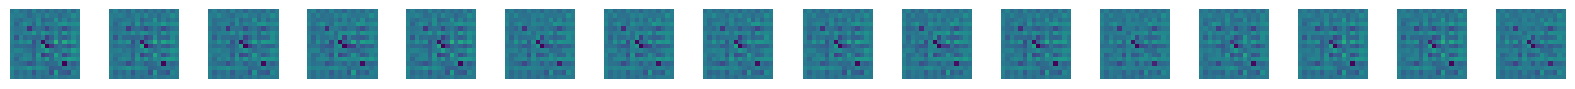

[Epoch 2/30] [D loss: 0.6343] [G loss: 1.1279] [Validity_loss: 0.2677] 
 [Stat_loss: 0.1600] [NNZ_loss: 0.7002]
Sample feature coding: [ 1.         -1.7740992   0.40741146  0.52191365  0.3922952   0.01032025
  0.04774502  0.00408918  0.01698022]


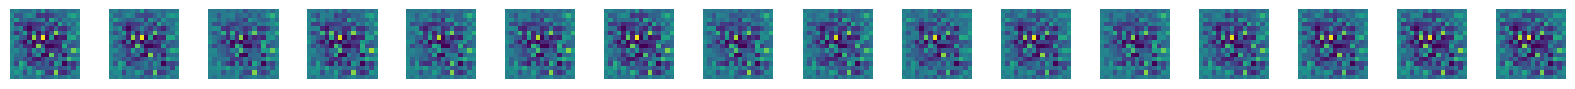

[Epoch 3/30] [D loss: 0.5768] [G loss: 1.1528] [Validity_loss: 0.3253] 
 [Stat_loss: 0.1262] [NNZ_loss: 0.7014]
Sample feature coding: [ 1.         -1.3313144   0.48021555  0.49084207  0.6382832   0.01073473
  0.05823063  0.00365465  0.04118793]


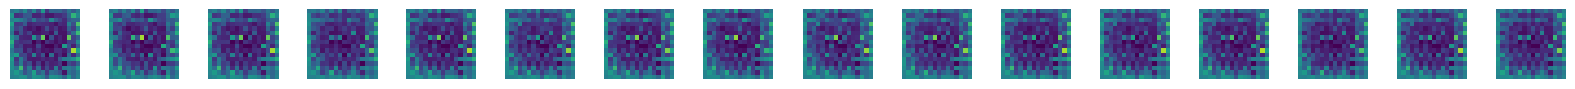

[Epoch 4/30] [D loss: 0.5244] [G loss: 1.1957] [Validity_loss: 0.3924] 
 [Stat_loss: 0.1008] [NNZ_loss: 0.7025]
Sample feature coding: [ 1.         -1.113099    0.10397822  0.5284199   0.91620845  0.01105205
  0.06327459  0.00360935  0.01756186]


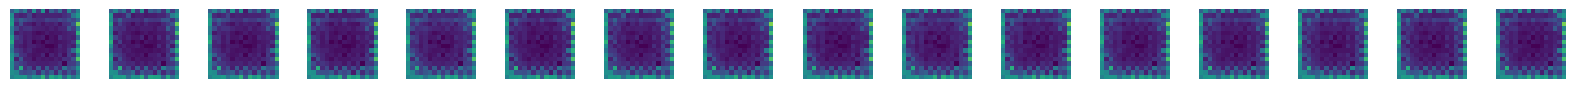

[Epoch 5/30] [D loss: 0.4834] [G loss: 1.2227] [Validity_loss: 0.4219] 
 [Stat_loss: 0.0878] [NNZ_loss: 0.7130]
Sample feature coding: [ 1.         -0.20184077  0.2010899   0.4544297   0.9206585   0.00990706
  0.07868297  0.00409693  0.03133722]


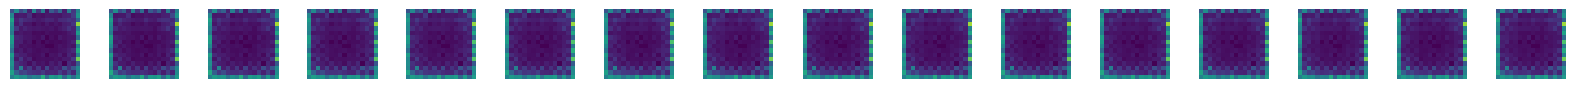

[Epoch 6/30] [D loss: 0.4353] [G loss: 1.2552] [Validity_loss: 0.4683] 
 [Stat_loss: 0.0702] [NNZ_loss: 0.7167]
Sample feature coding: [1.         2.0158076  0.7951809  0.6122196  0.55963826 0.0095265
 0.0384369  0.00381649 0.04085243]


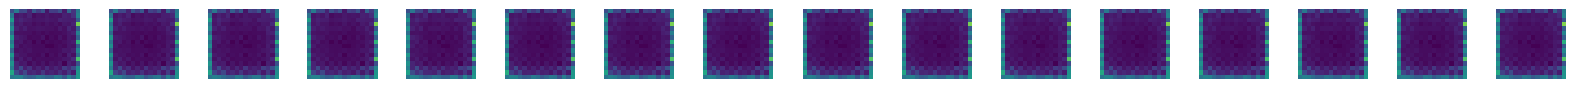

[Epoch 7/30] [D loss: 0.3922] [G loss: 1.2605] [Validity_loss: 0.4836] 
 [Stat_loss: 0.0581] [NNZ_loss: 0.7188]
Sample feature coding: [ 1.         -1.5697815   0.29467863  0.3766556   0.5728703   0.00936058
  0.06825729  0.0037136   0.030843  ]


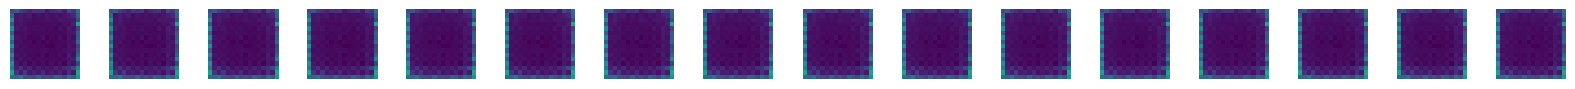

[Epoch 8/30] [D loss: 0.3559] [G loss: 1.2591] [Validity_loss: 0.5012] 
 [Stat_loss: 0.0529] [NNZ_loss: 0.7051]
Sample feature coding: [ 1.         -0.9060758   0.37229377  0.26698092  0.76690316  0.00954306
  0.05896366  0.00395191  0.03346469]


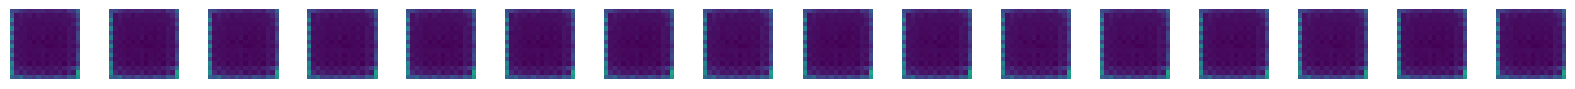

[Epoch 9/30] [D loss: 0.3138] [G loss: 1.2747] [Validity_loss: 0.5233] 
 [Stat_loss: 0.0491] [NNZ_loss: 0.7022]
Sample feature coding: [1.         1.4517037  0.2543738  0.01475005 0.74139494 0.01040766
 0.07332812 0.00402665 0.03864032]


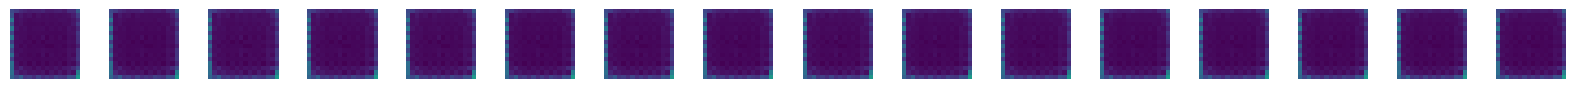

[Epoch 10/30] [D loss: 0.2780] [G loss: 1.2703] [Validity_loss: 0.5203] 
 [Stat_loss: 0.0451] [NNZ_loss: 0.7049]
Sample feature coding: [0.         1.0695202  0.95480525 0.06990597 0.6022588  0.0091631
 0.06641128 0.00389147 0.04224494]


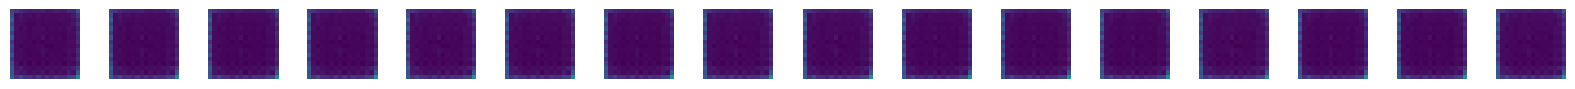

[Epoch 11/30] [D loss: 0.2502] [G loss: 1.2860] [Validity_loss: 0.5498] 
 [Stat_loss: 0.0371] [NNZ_loss: 0.6991]
Sample feature coding: [ 1.         -1.4086921   0.62273145  0.04187792  0.64405733  0.00968632
  0.05069027  0.00418518  0.01890871]


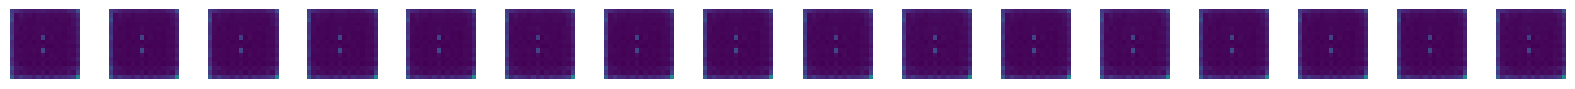

[Epoch 12/30] [D loss: 0.2459] [G loss: 1.3403] [Validity_loss: 0.6060] 
 [Stat_loss: 0.0280] [NNZ_loss: 0.7063]
Sample feature coding: [ 1.         -1.1697264   0.20647281  0.45907205  0.87649965  0.01143584
  0.06314576  0.00427154  0.03663304]


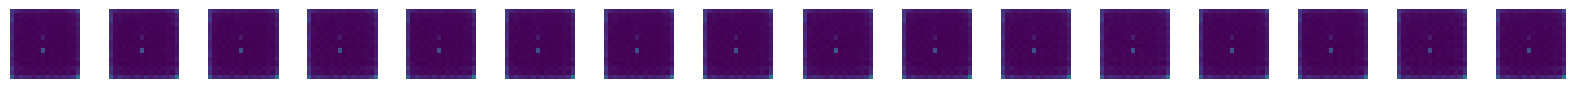

[Epoch 13/30] [D loss: 0.2505] [G loss: 1.2055] [Validity_loss: 0.4809] 
 [Stat_loss: 0.0213] [NNZ_loss: 0.7034]
Sample feature coding: [1.         0.11759479 0.7784241  0.55757433 0.5726994  0.01073427
 0.09080574 0.00360198 0.03499049]


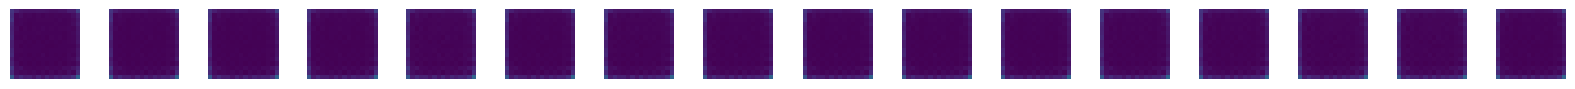

[Epoch 14/30] [D loss: 0.2338] [G loss: 1.2075] [Validity_loss: 0.4990] 
 [Stat_loss: 0.0150] [NNZ_loss: 0.6936]
Sample feature coding: [ 1.         -0.8136201   0.7806995   0.63387775  0.6275308   0.01152051
  0.06278714  0.00418009  0.03183788]


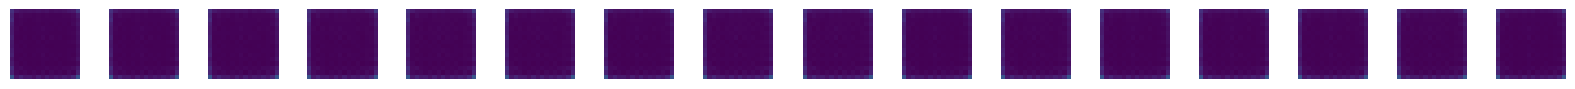

[Epoch 15/30] [D loss: 0.2147] [G loss: 1.2242] [Validity_loss: 0.5320] 
 [Stat_loss: 0.0103] [NNZ_loss: 0.6820]
Sample feature coding: [ 0.         -1.2250242   0.7124437   0.4860421   0.7442065   0.00916965
  0.03372378  0.0040076   0.02942545]


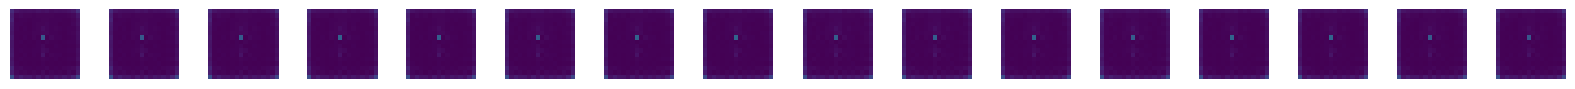

[Epoch 16/30] [D loss: 0.2953] [G loss: 1.5544] [Validity_loss: 0.8651] 
 [Stat_loss: 0.0105] [NNZ_loss: 0.6787]
Sample feature coding: [1.         1.8619267  1.0223515  0.8547017  0.72649705 0.00978391
 0.05517017 0.00398842 0.02670533]


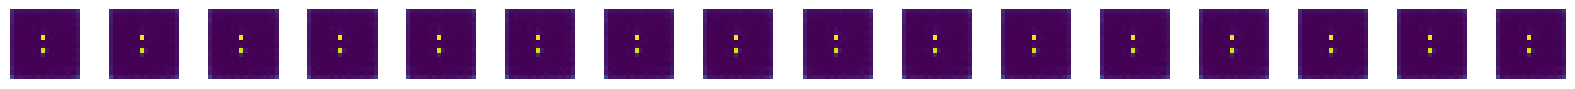

[Epoch 17/30] [D loss: 0.2520] [G loss: 1.2189] [Validity_loss: 0.5541] 
 [Stat_loss: 0.0076] [NNZ_loss: 0.6572]
Sample feature coding: [0.         0.7462008  0.3660575  0.62359583 0.57139826 0.01079926
 0.06049635 0.00390191 0.0335804 ]


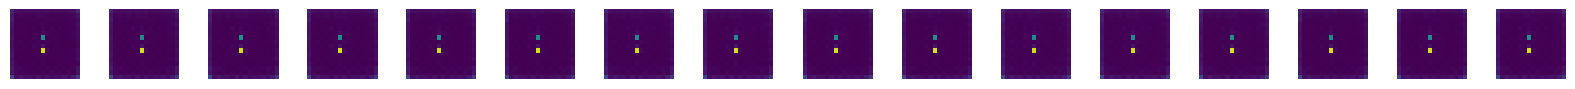

[Epoch 18/30] [D loss: 0.2808] [G loss: 1.1162] [Validity_loss: 0.4684] 
 [Stat_loss: 0.0050] [NNZ_loss: 0.6427]
Sample feature coding: [ 1.         -0.62744236  0.3198259   0.5219683   0.57869595  0.0093974
  0.06416315  0.00424408  0.04086098]


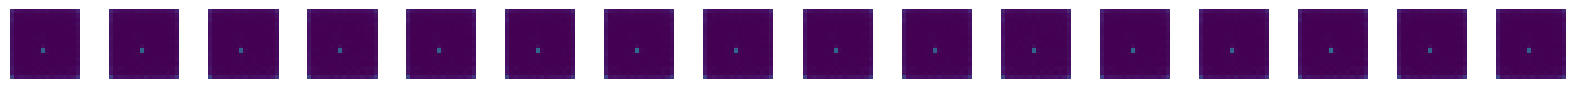

[Epoch 19/30] [D loss: 0.3876] [G loss: 0.9554] [Validity_loss: 0.3459] 
 [Stat_loss: 0.0042] [NNZ_loss: 0.6053]
Sample feature coding: [1.         0.47413343 0.9401894  0.3592458  0.4770572  0.01059229
 0.04849362 0.00386367 0.02267711]


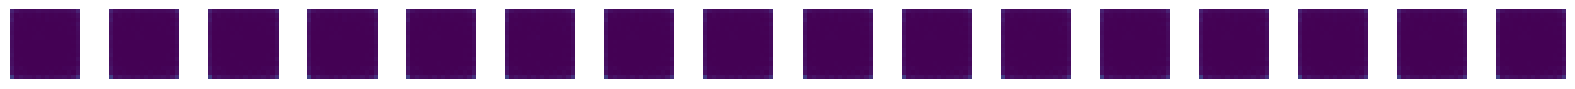

[Epoch 20/30] [D loss: 0.2895] [G loss: 0.9850] [Validity_loss: 0.4142] 
 [Stat_loss: 0.0031] [NNZ_loss: 0.5677]
Sample feature coding: [ 1.         -0.2017191   0.08396668  0.42300135  0.61433744  0.01053109
  0.06685966  0.00383217  0.02406353]


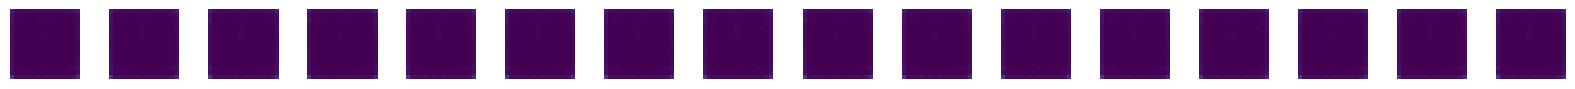

[Epoch 21/30] [D loss: 0.2106] [G loss: 1.0092] [Validity_loss: 0.4807] 
 [Stat_loss: 0.0019] [NNZ_loss: 0.5266]
Sample feature coding: [1.         0.846223   0.3682507  0.31525645 0.63079286 0.00880767
 0.05144779 0.00405787 0.03916522]


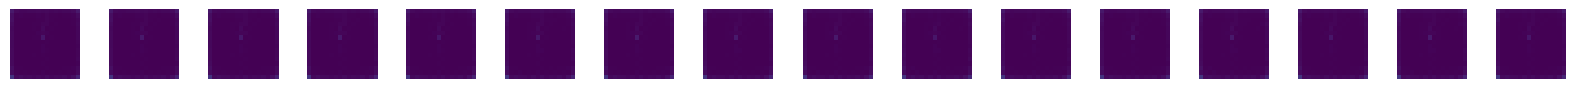

[Epoch 22/30] [D loss: 0.4020] [G loss: 1.0697] [Validity_loss: 0.5771] 
 [Stat_loss: 0.0024] [NNZ_loss: 0.4902]
Sample feature coding: [1.         1.1706276  0.6765217  0.22568111 0.625534   0.00981163
 0.04314599 0.00415534 0.02785609]


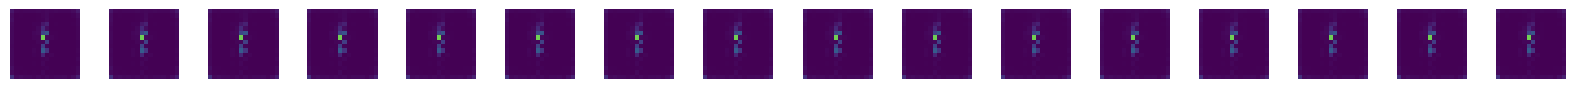

[Epoch 23/30] [D loss: 0.4125] [G loss: 1.1286] [Validity_loss: 0.6593] 
 [Stat_loss: 0.0025] [NNZ_loss: 0.4668]
Sample feature coding: [ 0.         -0.5392126   0.85600305  0.5451537   0.70500743  0.00819416
  0.08668225  0.00410025  0.01582805]


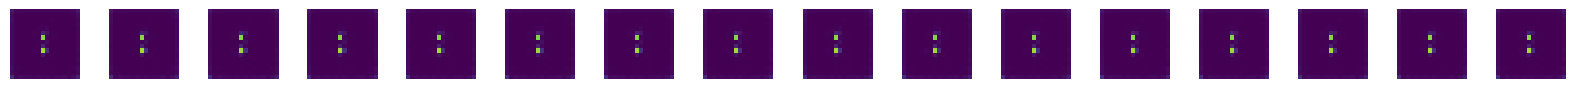

[Epoch 24/30] [D loss: 0.3757] [G loss: 0.9104] [Validity_loss: 0.4730] 
 [Stat_loss: 0.0016] [NNZ_loss: 0.4358]
Sample feature coding: [ 1.         -0.21515474  0.2591828   0.55627614  0.4707818   0.00840414
  0.06011306  0.00417204  0.01386193]


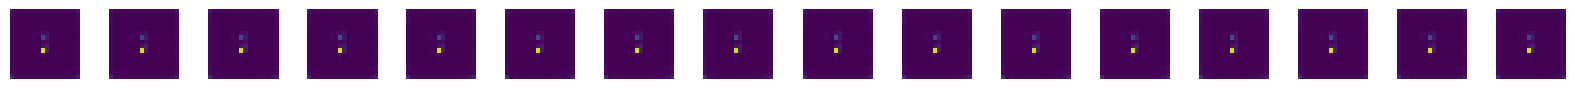

[Epoch 25/30] [D loss: 0.3082] [G loss: 0.9612] [Validity_loss: 0.5580] 
 [Stat_loss: 0.0009] [NNZ_loss: 0.4022]
Sample feature coding: [ 0.         -0.5954308   0.54523396  0.42654324  0.5272896   0.00919713
  0.05483903  0.00363275  0.02846544]


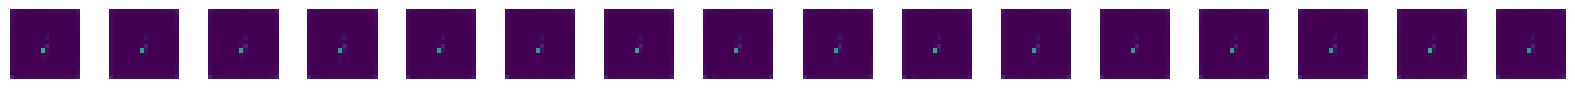

[Epoch 26/30] [D loss: 0.5974] [G loss: 0.5632] [Validity_loss: 0.1943] 
 [Stat_loss: 0.0007] [NNZ_loss: 0.3682]
Sample feature coding: [ 0.         -0.04670965  0.6554209   0.6379895   0.60804665  0.01083864
  0.03982347  0.00383787  0.04734955]


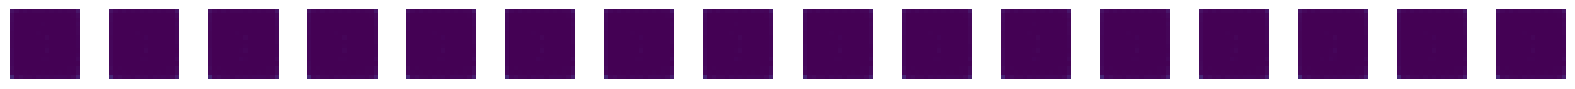

[Epoch 27/30] [D loss: 0.4177] [G loss: 0.6237] [Validity_loss: 0.3103] 
 [Stat_loss: 0.0007] [NNZ_loss: 0.3127]
Sample feature coding: [0.         1.9348679  0.32978392 0.4347227  0.5299083  0.00852451
 0.05200675 0.00432617 0.03894009]


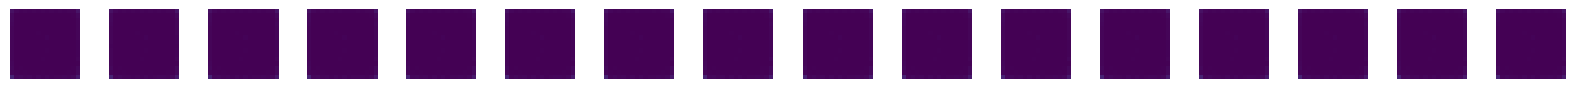

[Epoch 28/30] [D loss: 0.3102] [G loss: 0.6522] [Validity_loss: 0.3604] 
 [Stat_loss: 0.0004] [NNZ_loss: 0.2914]
Sample feature coding: [0.         2.190957   0.25156954 0.04277174 0.5546022  0.01004196
 0.05844384 0.00360964 0.02221256]


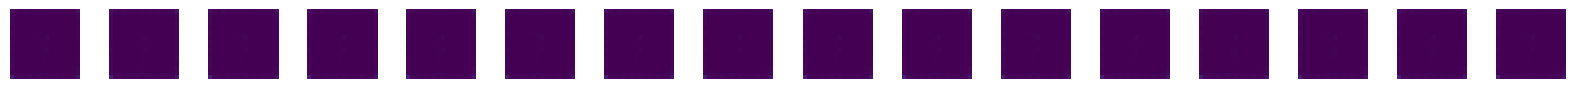

[Epoch 29/30] [D loss: 0.7824] [G loss: 0.4076] [Validity_loss: 0.1367] 
 [Stat_loss: 0.0003] [NNZ_loss: 0.2706]
Sample feature coding: [1.         0.80543435 0.11568103 0.38551834 0.6536433  0.00944479
 0.05805384 0.00381993 0.04317081]


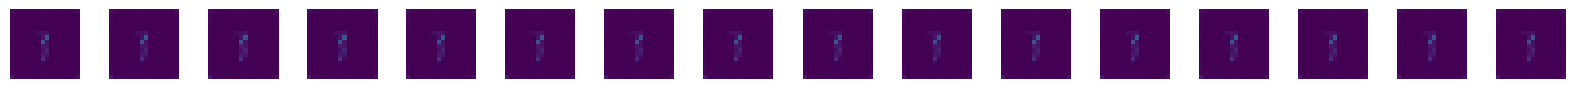

[Epoch 30/30] [D loss: 0.6629] [G loss: 1.3554] [Validity_loss: 1.1088] 
 [Stat_loss: 0.0016] [NNZ_loss: 0.2450]
Sample feature coding: [0.         0.9724743  0.9064526  0.58285064 0.46546844 0.01144746
 0.05079054 0.00439204 0.01872813]


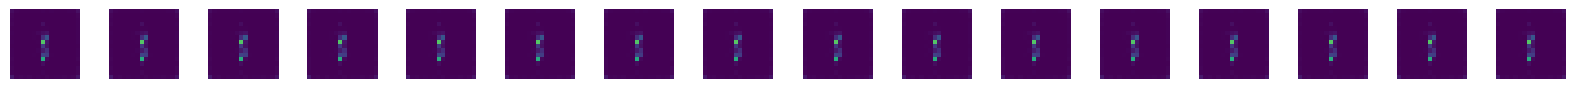

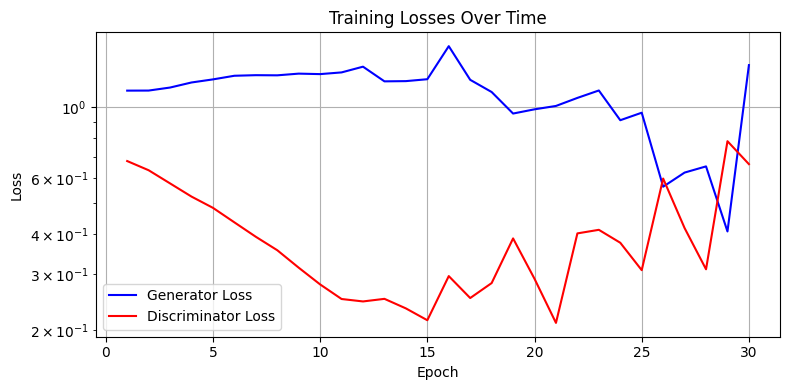

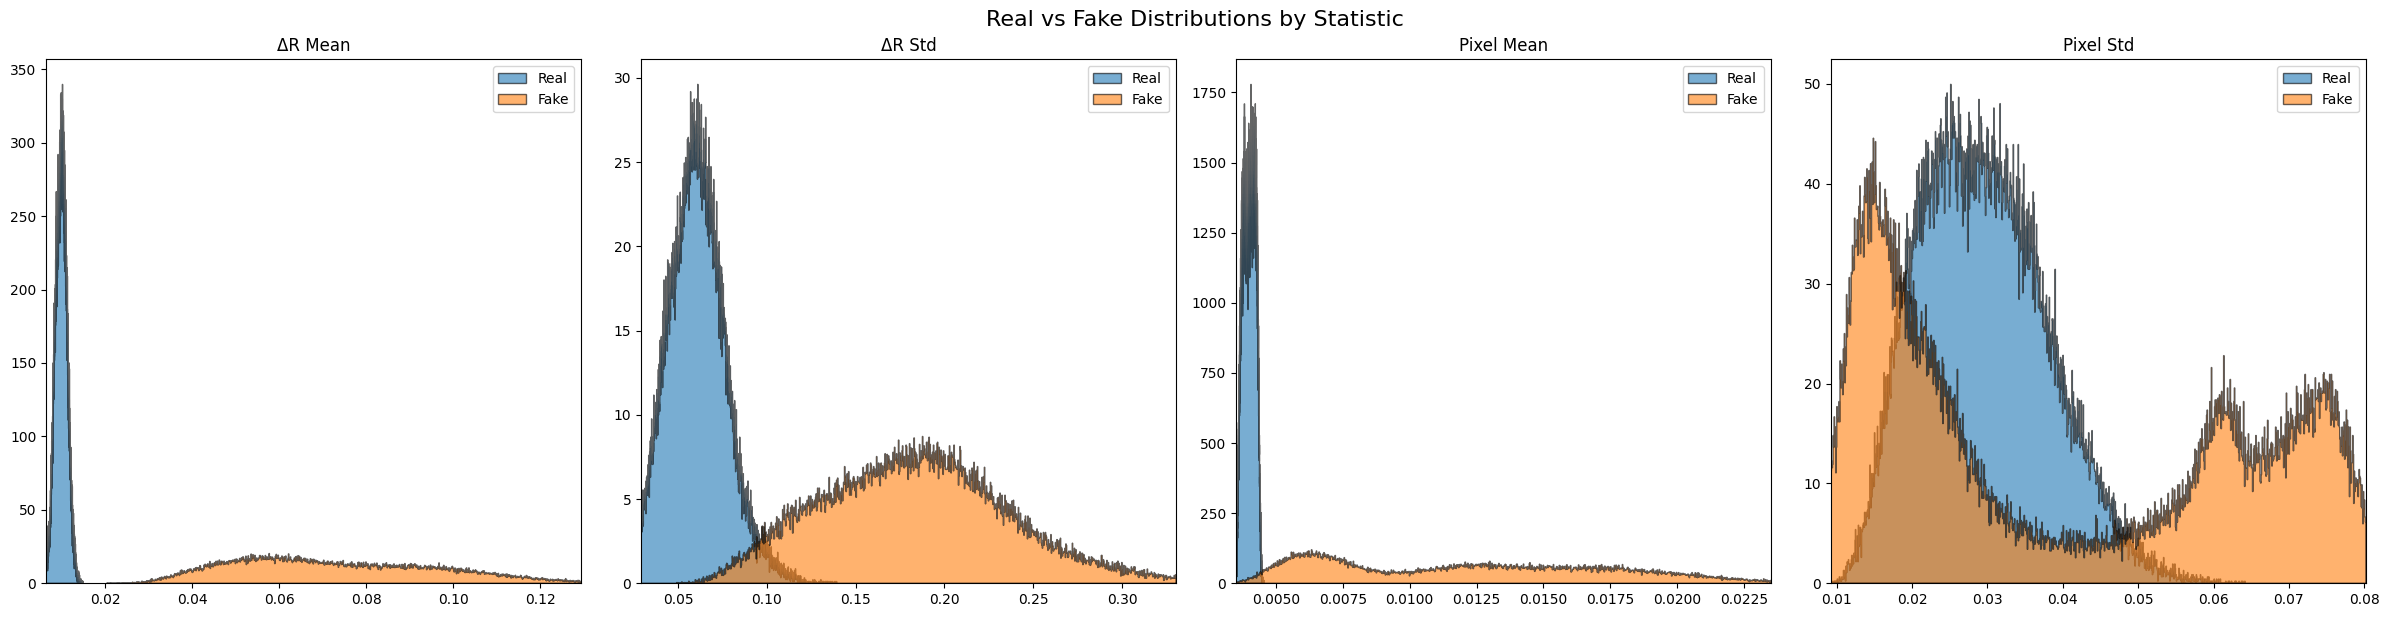

In [8]:
for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.to(device)
        real_flipped_feat = flipped_features.to(device)
        real_img = real_image.unsqueeze(1).to(device)
        real_flipped_img = flipped_image.unsqueeze(1).to(device)

        # print(f"Real: {real_img.shape}")

        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values get passed to the generator, then the output image passed to the discriminator
        
        # Discriminator training
        if i % 3 == 0:
            optimizer_D.zero_grad()
            discriminator.train()
            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).to(device)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)
            # print(f"Fake: {fake_img.shape}")

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:num]
            real_flipped_disc_codings = real_flipped_feat[:,:num]
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)

            ones = torch.ones(2*len(fake_pred))
            zeros = torch.zeros(2*len(real_pred))
            labels = (torch.cat([ones, zeros], dim=0)).to(device)

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()
            # generator.train()
            
            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).to(device)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1

            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]

            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)

            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)

            ## Stat loss
            # Compute fake statistics
            fake_stats = compute_fake_statistics(fake_img, dists)

            fake_dR_mean = fake_stats['fake_dR_mean']
            fake_dR_std = fake_stats['fake_dR_std']
            fake_pixel_mean = fake_stats['fake_pixel_mean']
            fake_pixel_std = fake_stats['fake_pixel_std']

            # Get real stats from z_codings (features 5–8)
            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]

            real_stats = {
                'real_dR_mean': real_dR_mean,
                'real_dR_std': real_dR_std,
                'real_pixel_mean': real_pixel_mean,
                'real_pixel_std': real_pixel_std
            }

            if n_epochs - epoch <= 10:
                # Track the last statistics
                track_statistics(stats_dict, fake_stats, real_stats)

            # Statistical MSE loss
            # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
            # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
            # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
            # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
            
            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # print(dR_mean_loss)
            # print(dR_std_loss)
            # print(3*pixel_mean_loss)
            # print(2*pixel_std_loss)

            # Statistical KL Divergence loss
            kl_total = 0
            kl1 = kde_kl_divergence_torch(real_dR_mean, fake_dR_mean) / 0.03
            # print(f"KL(real_dR_mean, fake_dR_mean) = {kl1.item()}")
            
            kl2 = kde_kl_divergence_torch(real_dR_std, fake_dR_std) / 0.003
            # print(f"KL(real_dR_std, fake_dR_std) = {kl2.item()}")
            
            kl3 = kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean) / 0.0005  # Avoid division by zero
            # print(f"KL(real_pixel_mean, fake_pixel_mean) = {kl3.item()}")
            
            kl4 = kde_kl_divergence_torch(real_pixel_std, fake_pixel_std) / 0.0001
            # print(f"KL(real_pixel_std, fake_pixel_std) = {kl4.item()}")
            
            kl_total = kl1 + kl2 + kl3 + kl4


            stat_loss = kl_total

            # Number non-zero loss
            fake_nnz = soft_count_nonzero(fake_img, threshold=3e-5, sharpness=10000.0)
            real_nnz = soft_count_nonzero(real_img, threshold=3e-5, sharpness=10000.0)
            nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            
            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .15
            beta = .00005
            chi = .00005

            g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss)

            g_loss.backward()
            optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[-1]:.4f}] [G loss: {g_losses[-1]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

    plot_generated_samples(generator, dataset, kdes, batch_size=16, latent_dim=256)

plot_metrics(g_losses, d_losses)

plot_tracked_statistics(stats_dict)

In [9]:
## Save Model
# Create output directory if it doesn't exist

save = False

if save:
    os.makedirs("models", exist_ok=True)
    
    # Timestamp for unique filenames
    timestamp = datetime.now().strftime("m%d_%H%M")
    
    # Save model states and tracked data in a single file
    save_path = f"models/Q_gan_short_model_{timestamp}.pt"
    torch.save({
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "g_losses": g_losses,
        "d_losses": d_losses,
        "stats_dict": stats_dict
    }, save_path)
    
    print(f"Model and statistics saved to {save_path}")

![image.png](attachment:7aee3b98-579c-4bcb-9682-eb417b7e3a7a.png)

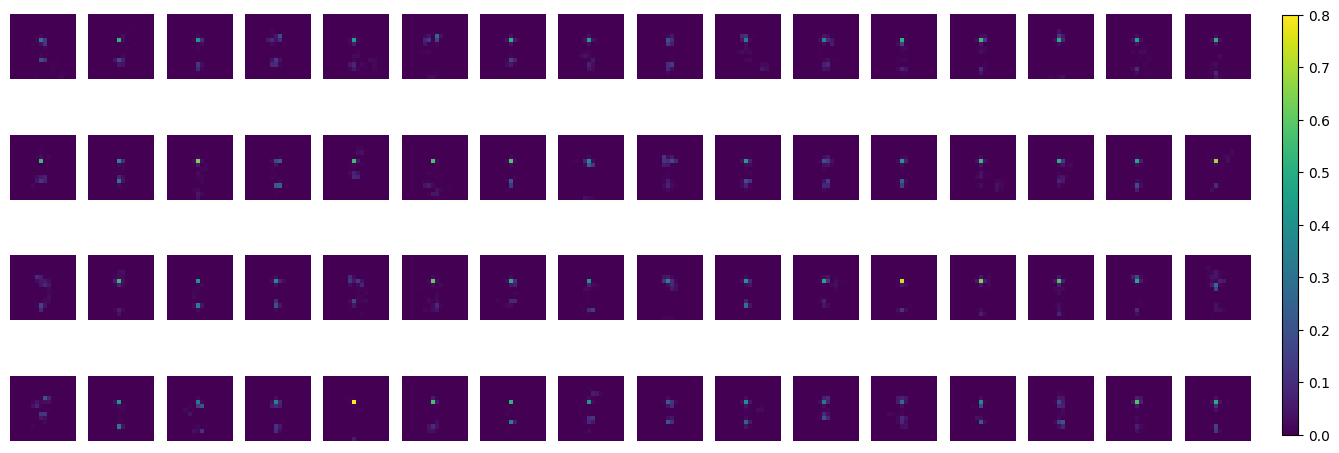

In [10]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = dataset.images[:n_images].min()
vmax = dataset.images[:n_images].max()

# Show images and keep the first imshow object for colorbar
im = None
for i in range(n_images):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(dataset.images[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

Sample feature coding: [ 1.         -1.6483437   0.40225106  0.5956567   0.36457172  0.00973841
  0.06457625  0.00374601  0.03893102]


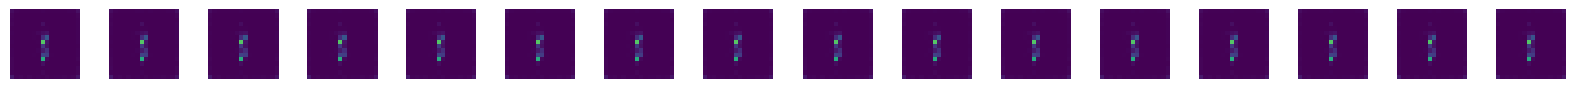

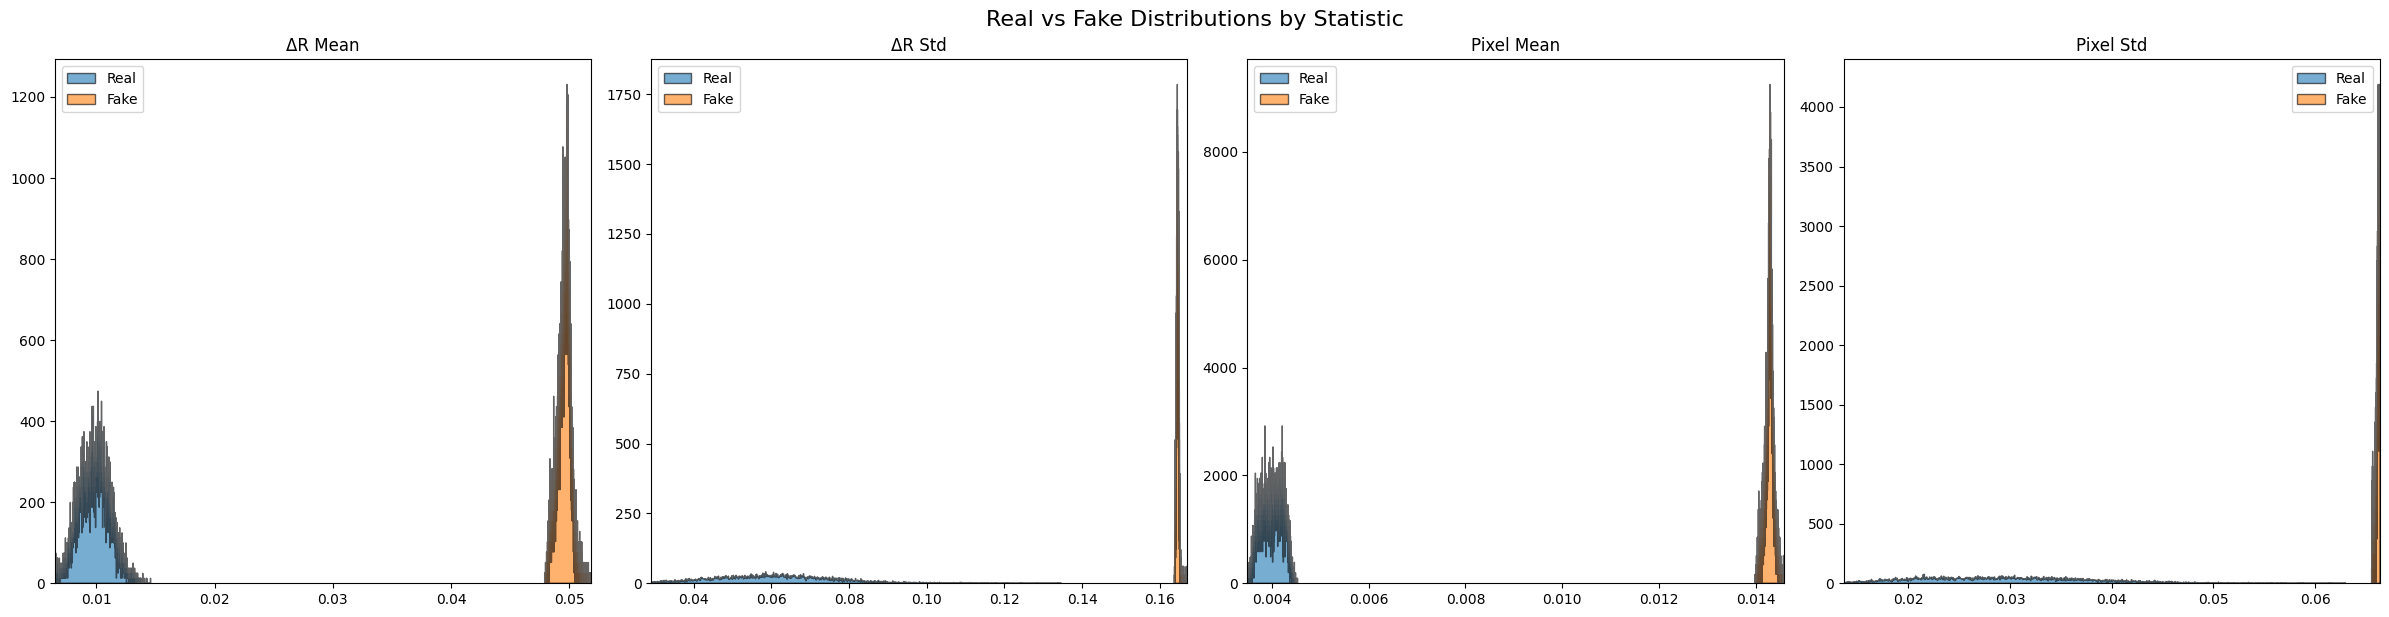

Discriminator output (wrong label): [0.18135276 0.30095634 0.35668936 ... 0.23839763 0.2118446  0.39575014]
Discriminator output (correct label): [0.146742   0.24294053 0.31051168 ... 0.23839763 0.2118446  0.39575014]
Real labels: [1. 1. 1. ... 0. 0. 0.]
Swapped labels: [0. 0. 0. ... 0. 0. 0.]
Relative change (%): [23.58613  23.880661 14.871478 ...  0.        0.        0.      ]


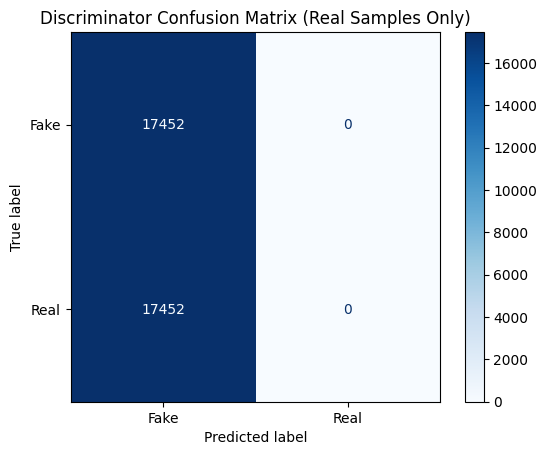

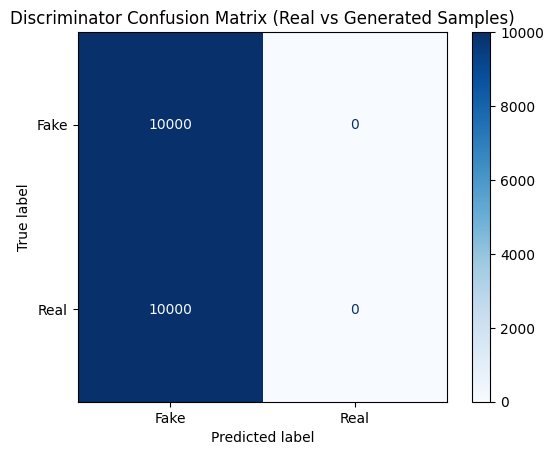

In [11]:
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=10000)

# Optional args:
#     generator,
#     discriminator,
#     dataset,
#     kdes,
#     batch_size=16,
#     latent_dim=256,
#     codings=None,
#     plot_distributions=True,
#     compare_discriminator=True